In [3]:
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report


In [4]:
# datasets
drug_reviews_drugs_com = fetch_ucirepo(id=462)
drug_reviews_druglib_com = fetch_ucirepo(id=461)

# Load the datasets
df1 = drug_reviews_drugs_com.data.features
df2 = drug_reviews_druglib_com.data.features


In [5]:
# Combine datasets
combined_df = pd.concat([df1, df2], ignore_index=True)


In [7]:
## Exploratory Data Analysis (EDA)

In [8]:
print(combined_df.head())
print(combined_df.info())
print("Unique Drug Names:", combined_df['urlDrugName'].nunique())
print("Unique Conditions:", combined_df['condition'].nunique())


                   drugName                     condition  \
0                 Valsartan  Left Ventricular Dysfunction   
1                Guanfacine                          ADHD   
2                    Lybrel                 Birth Control   
3                Ortho Evra                 Birth Control   
4  Buprenorphine / naloxone             Opiate Dependence   

                                              review  rating       date  \
0  "It has no side effect, I take it in combinati...       9  20-May-12   
1  "My son is halfway through his fourth week of ...       8  27-Apr-10   
2  "I used to take another oral contraceptive, wh...       5  14-Dec-09   
3  "This is my first time using any form of birth...       8   3-Nov-15   
4  "Suboxone has completely turned my life around...       9  27-Nov-16   

   usefulCount urlDrugName effectiveness sideEffects benefitsReview  \
0         27.0         NaN           NaN         NaN            NaN   
1        192.0         NaN           NaN

In [9]:
print(combined_df.describe())
print(combined_df['rating'].value_counts())


              rating    usefulCount
count  219206.000000  215063.000000
mean        6.989184      28.001004
std         3.269682      36.346069
min         1.000000       0.000000
25%         5.000000       6.000000
50%         8.000000      16.000000
75%        10.000000      36.000000
max        10.000000    1291.000000
rating
10    68973
9     37321
1     29338
8     25794
7     13018
5     10949
2      9401
3      8913
6      8677
4      6822
Name: count, dtype: int64


In [10]:
# Convert reviews to string and calculate lengths
#converts review data into string format calculates the length of each review, stores those lengths in new columns
combined_df['benefitsLength'] = combined_df['benefitsReview'].astype(str).apply(len)
combined_df['sideEffectsLength'] = combined_df['sideEffectsReview'].astype(str).apply(len)
combined_df['commentsLength'] = combined_df['commentsReview'].astype(str).apply(len)

# Display descriptive statistics (lengths)
print(combined_df[['benefitsLength', 'sideEffectsLength', 'commentsLength']].describe())


       benefitsLength  sideEffectsLength  commentsLength
count   219206.000000      219206.000000   219206.000000
mean         6.870387           6.366254        8.205993
std         38.535313          36.961314       53.693841
min          2.000000           2.000000        1.000000
25%          3.000000           3.000000        3.000000
50%          3.000000           3.000000        3.000000
75%          3.000000           3.000000        3.000000
max       2296.000000        2551.000000     3859.000000


In [11]:
# Descriptive statistics for numerical columns
print(combined_df.describe())

# distribution of the rating column
print(combined_df['rating'].value_counts())


              rating    usefulCount  benefitsLength  sideEffectsLength  \
count  219206.000000  215063.000000   219206.000000      219206.000000   
mean        6.989184      28.001004        6.870387           6.366254   
std         3.269682      36.346069       38.535313          36.961314   
min         1.000000       0.000000        2.000000           2.000000   
25%         5.000000       6.000000        3.000000           3.000000   
50%         8.000000      16.000000        3.000000           3.000000   
75%        10.000000      36.000000        3.000000           3.000000   
max        10.000000    1291.000000     2296.000000        2551.000000   

       commentsLength  
count   219206.000000  
mean         8.205993  
std         53.693841  
min          1.000000  
25%          3.000000  
50%          3.000000  
75%          3.000000  
max       3859.000000  
rating
10    68973
9     37321
1     29338
8     25794
7     13018
5     10949
2      9401
3      8913
6      8677
4 

/var/folders/62/mz1wg80n407bz3b_1h0t6szc0000gn/T/ipykernel_32830/2051441538.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=combined_df, x='rating', palette='viridis')


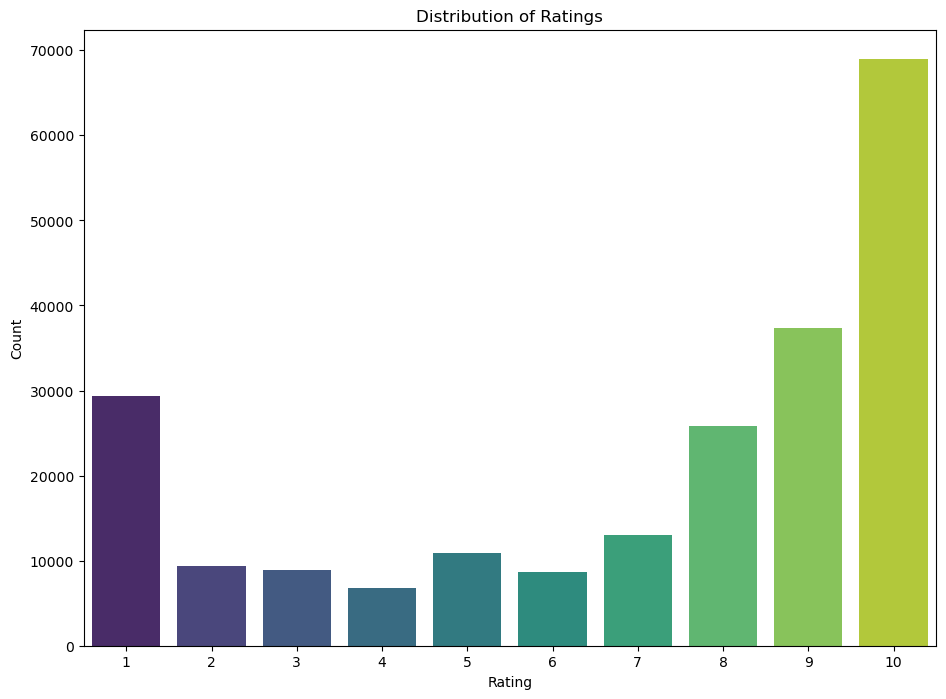

In [12]:
plt.figure(figsize=(11, 8))
sns.countplot(data=combined_df, x='rating', palette='viridis')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


/var/folders/62/mz1wg80n407bz3b_1h0t6szc0000gn/T/ipykernel_32830/2744593534.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=combined_df, x='effectiveness', palette='plasma')


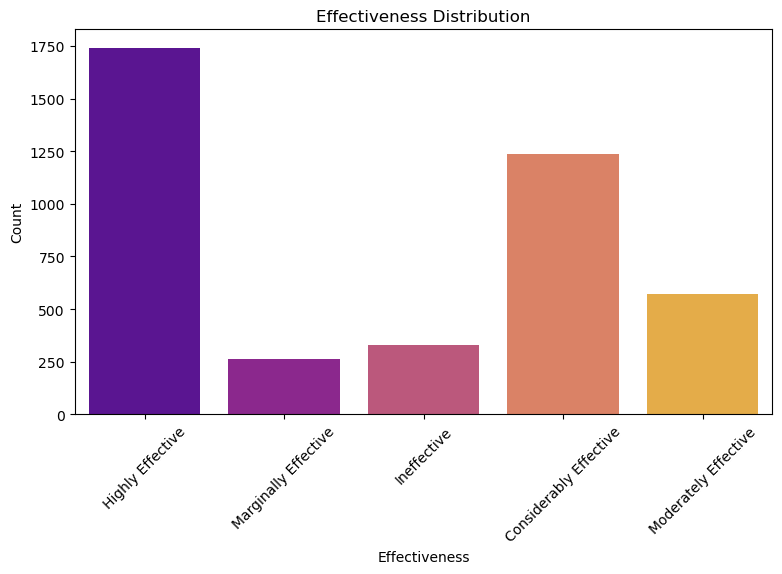

In [13]:
plt.figure(figsize=(9, 5))
sns.countplot(data=combined_df, x='effectiveness', palette='plasma')
plt.title('Effectiveness Distribution')
plt.xlabel('Effectiveness')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


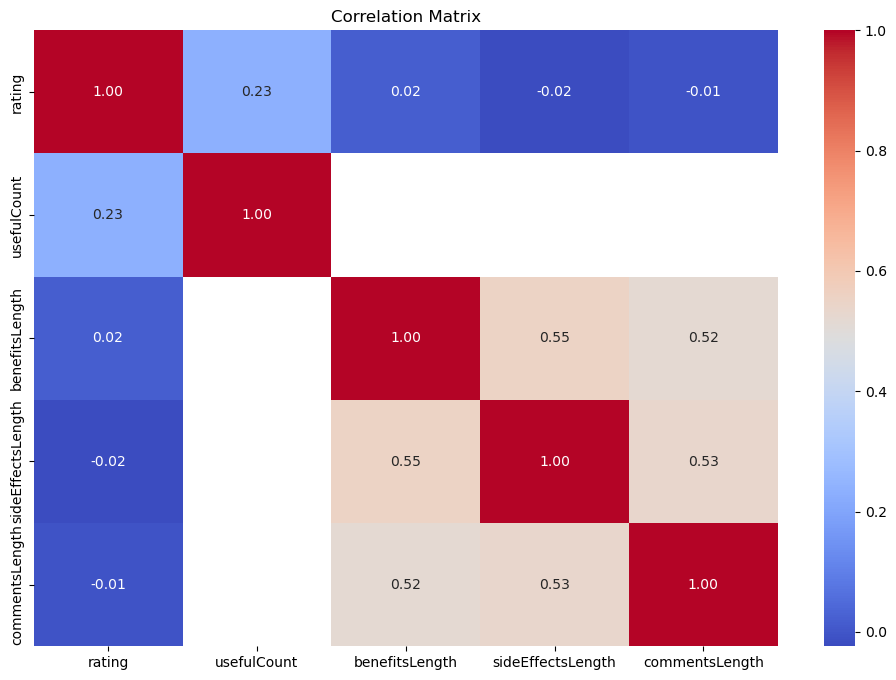

In [14]:
# Select only numeric columns for correlation calculation
numeric_df = combined_df.select_dtypes(include=[np.number])

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


/var/folders/62/mz1wg80n407bz3b_1h0t6szc0000gn/T/ipykernel_19634/222194845.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=combined_df[combined_df['usefulCount'].isin(top_useful_counts.index)],


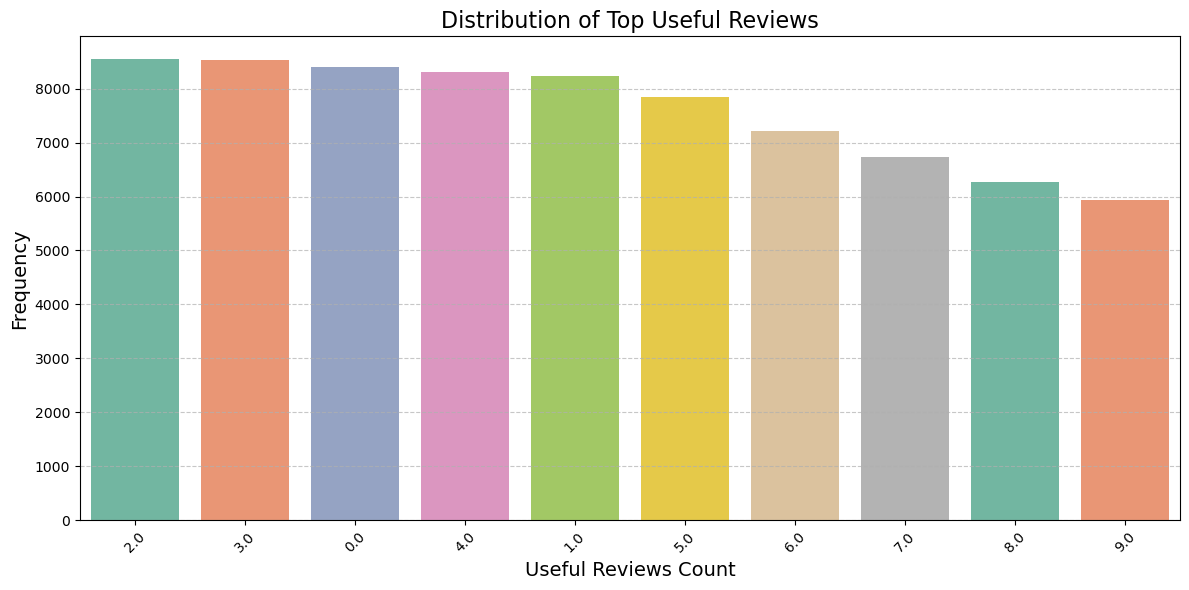

In [24]:

# Determine the top N useful review counts USING TOP #10
top_n = 10 
top_useful_counts = combined_df['usefulCount'].value_counts().nlargest(top_n)

plt.figure(figsize=(12, 6))

# the top N useful reviews
sns.countplot(data=combined_df[combined_df['usefulCount'].isin(top_useful_counts.index)],
                            x='usefulCount', palette='Set2', order=top_useful_counts.index)

# Customize the plot
plt.title('Distribution of Top Useful Reviews', fontsize=16)
plt.xlabel('Useful Reviews Count', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.grid(axis='y', linestyle='--', alpha=0.7)  # grid for better readability
plt.tight_layout()  

# Show the plot
plt.show()



In [40]:
def rename_columns(df):
    df = df.rename(columns={
        'urlDrugName': 'drug_name',
        'sideEffects': 'side_effects',
        'benefitsReview': 'benefits_review',
        'sideEffectsReview': 'side_effects_review',
        'commentsReview': 'comments_review'  # Include comments column
    })
    return df

# Rename columns in both DataFrames
df1 = rename_columns(df1)
df2 = rename_columns(df2)

# Check the column names after renaming
print("Columns in Dataset 1:", df1.columns)
print("Columns in Dataset 2:", df2.columns)

# Combine specified columns into a single 'reviews' column
df2['reviews'] = df2[['benefits_review', 'side_effects_review', 'comments_review']].apply(
    lambda x: ' '.join(x.dropna()), axis=1
)

# Display the updated DataFrame with the new 'reviews' column
print(df2[['reviews']].head(5))


Columns in Dataset 1: Index(['drugName', 'condition', 'review', 'rating', 'date', 'usefulCount'], dtype='object')
Columns in Dataset 2: Index(['drug_name', 'rating', 'effectiveness', 'side_effects', 'condition',
       'benefits_review', 'side_effects_review', 'comments_review', 'reviews'],
      dtype='object')
                                             reviews
0  slowed the progression of left ventricular dys...
1  Although this type of birth control has more c...
2  I was used to having cramps so badly that they...
3  The acid reflux went away for a few months aft...
4  I think that the Lyrica was starting to help w...


'drug_name' column not found in Dataset 1.


<Figure size 1200x600 with 0 Axes>

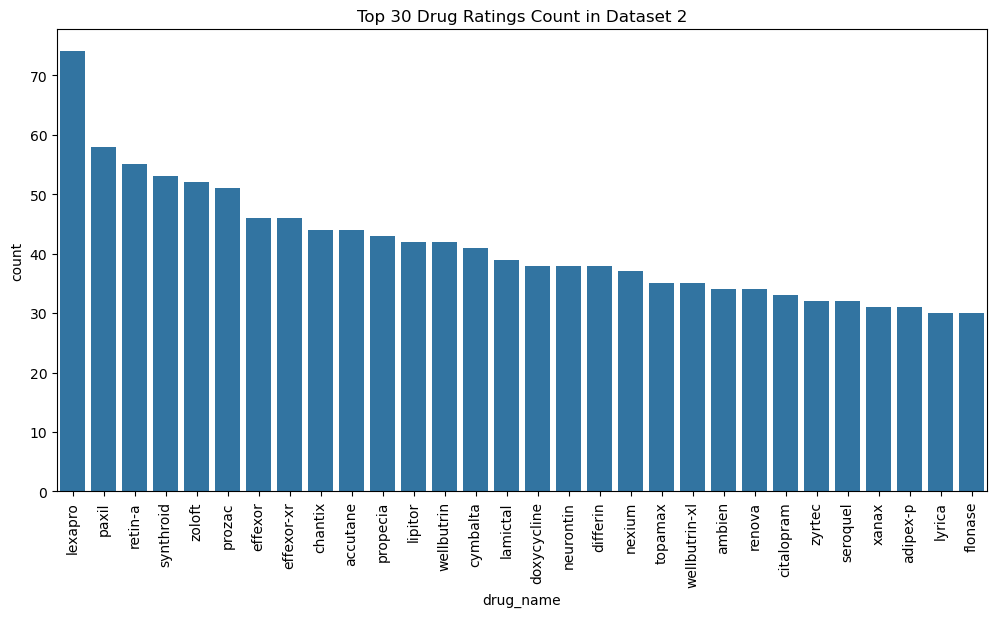

In [42]:
def plot_drug_ratings(df, dataset_name, top_n=30):
    plt.figure(figsize=(12, 6))
    
    # Check if drug_name exists 
    if 'drug_name' in df.columns:
        # Get the top N drugs based on count
        top_drugs = df['drug_name'].value_counts().nlargest(top_n).index
        sns.countplot(data=df[df['drug_name'].isin(top_drugs)], x='drug_name', order=top_drugs)
        plt.title(f'Top {top_n} Drug Ratings Count in {dataset_name}')
        plt.xticks(rotation=90)
        plt.show()
    else:
        print(f"'drug_name' column not found in {dataset_name}.")

# Plot for both datasets
plot_drug_ratings(df1, "Dataset 1", top_n=30)
plot_drug_ratings(df2, "Dataset 2", top_n=30)


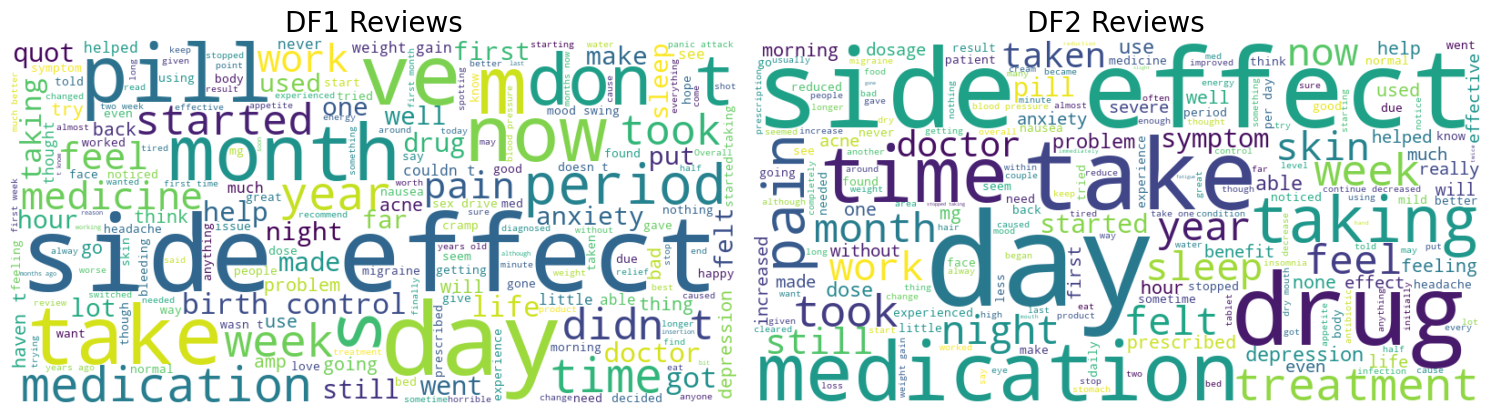

In [52]:
df1_reviews = ' '.join(df1['review'].dropna().astype(str))
wordcloud_df1 = WordCloud(width=800, height=400, background_color='white').generate(df1_reviews)

# Generate word cloud for df2
df2_reviews = ' '.join(df2['reviews'].dropna().astype(str))
wordcloud_df2 = WordCloud(width=800, height=400, background_color='white').generate(df2_reviews)

# Set up the plot for both word clouds
plt.figure(figsize=(15, 10))

# Plot for df1
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_df1, interpolation='bilinear')
plt.axis('off')  # Turn off axis numbers and ticks
plt.title("DF1 Reviews", fontsize=20)

# Plot for df2
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_df2, interpolation='bilinear')
plt.axis('off')  # Turn off axis numbers and ticks
plt.title("DF2 Reviews", fontsize=20)

# Show the plots
plt.tight_layout()
plt.show()

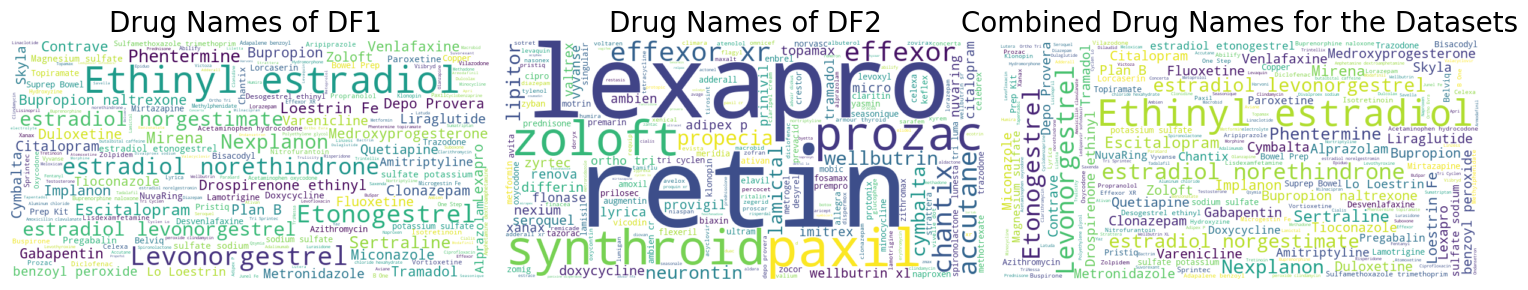

In [53]:
# Generate word cloud for df1 drug names
df1_drug_names = ' '.join(df1['drugName'].dropna().astype(str))
wordcloud_df1 = WordCloud(width=800, height=400, background_color='white').generate(df1_drug_names)

# Generate word cloud for df2 drug names
df2_drug_names = ' '.join(df2['drug_name'].dropna().astype(str))
wordcloud_df2 = WordCloud(width=800, height=400, background_color='white').generate(df2_drug_names)

# Combine drug names for both datasets
combined_drug_names = df1_drug_names + ' ' + df2_drug_names
wordcloud_combined = WordCloud(width=800, height=400, background_color='white').generate(combined_drug_names)

# Set up the plot for all three word clouds
plt.figure(figsize=(15, 10))

# Plot for df1
plt.subplot(1, 3, 1)
plt.imshow(wordcloud_df1, interpolation='bilinear')
plt.axis('off')  # Turn off axis numbers and ticks
plt.title("Drug Names of DF1 ", fontsize=20)

# Plot for df2
plt.subplot(1, 3, 2)
plt.imshow(wordcloud_df2, interpolation='bilinear')
plt.axis('off')  # Turn off axis numbers and ticks
plt.title("Drug Names of DF2", fontsize=20)

# Plot for combined drug names
plt.subplot(1, 3, 3)
plt.imshow(wordcloud_combined, interpolation='bilinear')
plt.axis('off')  # Turn off axis numbers and ticks
plt.title("Combined Drug Names for the Datasets", fontsize=20)

# Show the plots
plt.tight_layout()
plt.show()


'benefits_review' column not found in the DataFrame.


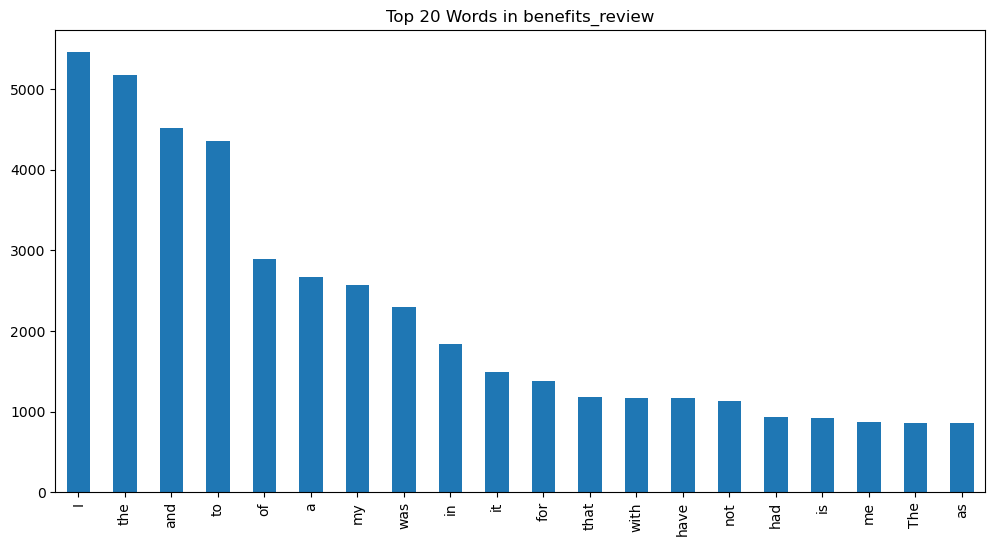

In [58]:
def plot_word_frequency(df, column_name):
    if column_name in df.columns:
        all_reviews = ' '.join(df[column_name].dropna())
        words = all_reviews.split()
        word_freq = pd.Series(words).value_counts().head(20)  
        word_freq.plot(kind='bar', figsize=(12, 6))
        plt.title(f'Top 20 Words in {column_name}')
        plt.show()
    else:
        print(f"'{column_name}' column not found in the DataFrame.")

# Plot for benefits reviews
plot_word_frequency(df1, 'benefits_review')
plot_word_frequency(df2, 'benefits_review')


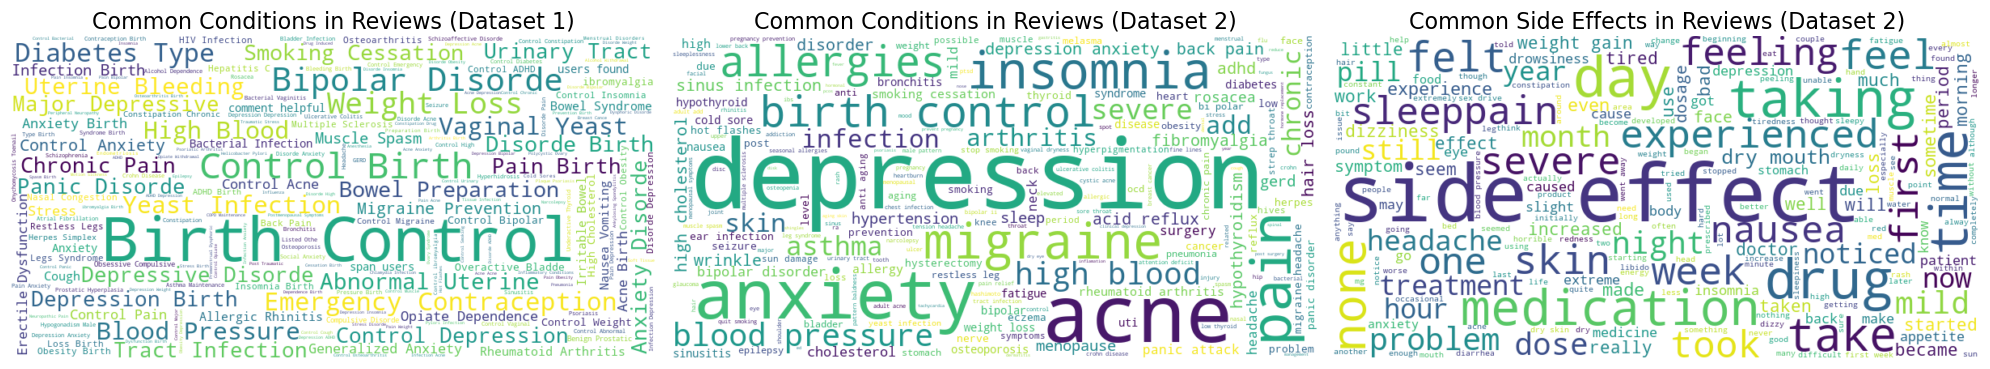

In [64]:
# Generate word cloud for conditions in df1
condition_text_df1 = ' '.join(df1['condition'].dropna())
wordcloud_conditions_df1 = WordCloud(width=800, height=400, background_color='white').generate(condition_text_df1)

# Generate word cloud for conditions in df2
condition_text_df2 = ' '.join(df2['condition'].dropna())
wordcloud_conditions_df2 = WordCloud(width=800, height=400, background_color='white').generate(condition_text_df2)

# Generate word cloud for side effects in df2
side_effects_text = ' '.join(df2['side_effects_review'].dropna())
wordcloud_side_effects = WordCloud(width=800, height=400, background_color='white').generate(side_effects_text)

# Set up the plot for all three word clouds
plt.figure(figsize=(20, 7))

# Plot for conditions in df1
plt.subplot(1, 3, 1)
plt.imshow(wordcloud_conditions_df1, interpolation='bilinear')
plt.axis('off')
plt.title('Common Conditions in Reviews (Dataset 1)', fontsize=16)

# Plot for conditions in df2
plt.subplot(1, 3, 2)
plt.imshow(wordcloud_conditions_df2, interpolation='bilinear')
plt.axis('off')
plt.title('Common Conditions in Reviews (Dataset 2)', fontsize=16)

# Plot for side effects in df2
plt.subplot(1, 3, 3)
plt.imshow(wordcloud_side_effects, interpolation='bilinear')
plt.axis('off')
plt.title('Common Side Effects in Reviews (Dataset 2)', fontsize=16)

# Show the plots
plt.tight_layout()
plt.show()



In [42]:
# Function to clean text (remove punctuation, lowercase, remove numbers)
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()  
        text = re.sub(r'\d+', '', text)  
        text = re.sub(r'[^\w\s]', '', text)  
    return text

# Apply the cleaning function to the review column
df1['cleaned_review'] = df1['review'].apply(clean_text)

# Check cleaned reviews
print("Cleaned review:", df1['cleaned_review'].head())


Cleaned review: 0    it has no side effect i take it in combination...
1    my son is halfway through his fourth week of i...
2    i used to take another oral contraceptive whic...
3    this is my first time using any form of birth ...
4    suboxone has completely turned my life around ...
Name: cleaned_review, dtype: object


In [44]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')  
# Set of English stop words
stop_words = set(stopwords.words('english'))

# Function to clean text 
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()  
        text = re.sub(r'\d+', '', text)  
        text = re.sub(r'[^\w\s]', '', text)
    return text

# Function to tokenize and remove stopwords
def tokenize_and_remove_stopwords(text):
    if isinstance(text, str):
        words = word_tokenize(text)
        words = [word for word in words if word not in stop_words]
        return words
    return []  # Return an empty list if text is not a string

# Clean the review column
df1['cleaned_review'] = df1['review'].apply(clean_text)

# Apply tokenization and stopword removal
df1['tokens_review'] = df1['cleaned_review'].apply(tokenize_and_remove_stopwords)

# tokenized data
print("Tokenized review:", df1['tokens_review'].head())


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/katerineosorio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/katerineosorio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/katerineosorio/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Tokenized review: 0    [side, effect, take, combination, bystolic, mg...
1    [son, halfway, fourth, week, intuniv, became, ...
2    [used, take, another, oral, contraceptive, pil...
3    [first, time, using, form, birth, control, im,...
4    [suboxone, completely, turned, life, around, f...
Name: tokens_review, dtype: object


In [45]:
nltk.download('wordnet')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to lemmatize words
def lemmatize_words(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]

# Apply lemmatization
df1['lemmatized_review'] = df1['tokens_review'].apply(lemmatize_words)

# lemmatized data
print("Lemmatized review:", df1['lemmatized_review'].head())


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/katerineosorio/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Lemmatized review: 0    [side, effect, take, combination, bystolic, mg...
1    [son, halfway, fourth, week, intuniv, became, ...
2    [used, take, another, oral, contraceptive, pil...
3    [first, time, using, form, birth, control, im,...
4    [suboxone, completely, turned, life, around, f...
Name: lemmatized_review, dtype: object


In [47]:
# Check for the lemmatized review column
if 'lemmatized_review' in df1.columns:
    # Use the entire dataset for TF-IDF
    text_column = df1['lemmatized_review'].astype(str)
    
    # Initialize TF-IDF Vectorizer
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=500)
    X_tfidf = tfidf_vectorizer.fit_transform(text_column)

    # Display the shape of the TF-IDF matrix
    print("TF-IDF matrix shape:", X_tfidf.shape)

TF-IDF matrix shape: (215063, 500)


TF-IDF matrix shape: (215063, 500)
Top TF-IDF terms:
 day       0.054130
month     0.042913
year      0.042557
pain      0.039958
effect    0.039835
week      0.038042
im        0.036984
taking    0.036665
mg        0.035442
work      0.034980
dtype: float64


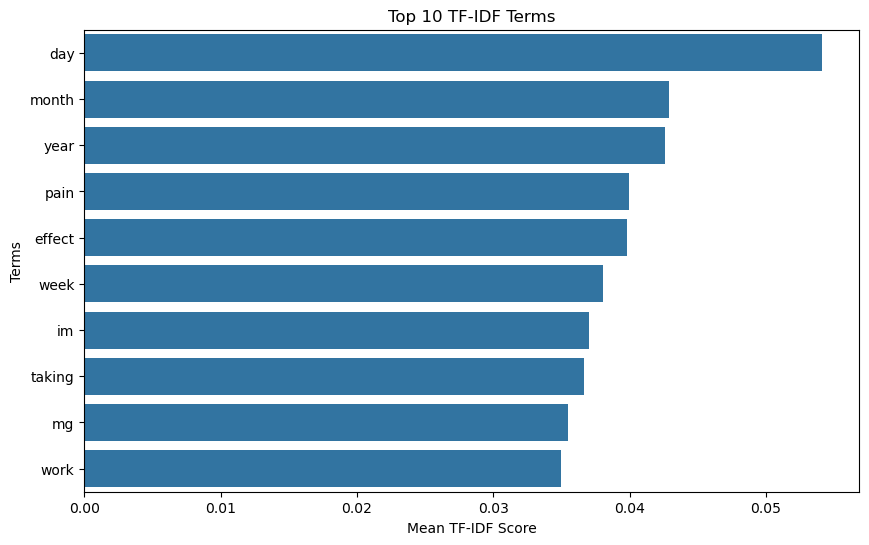

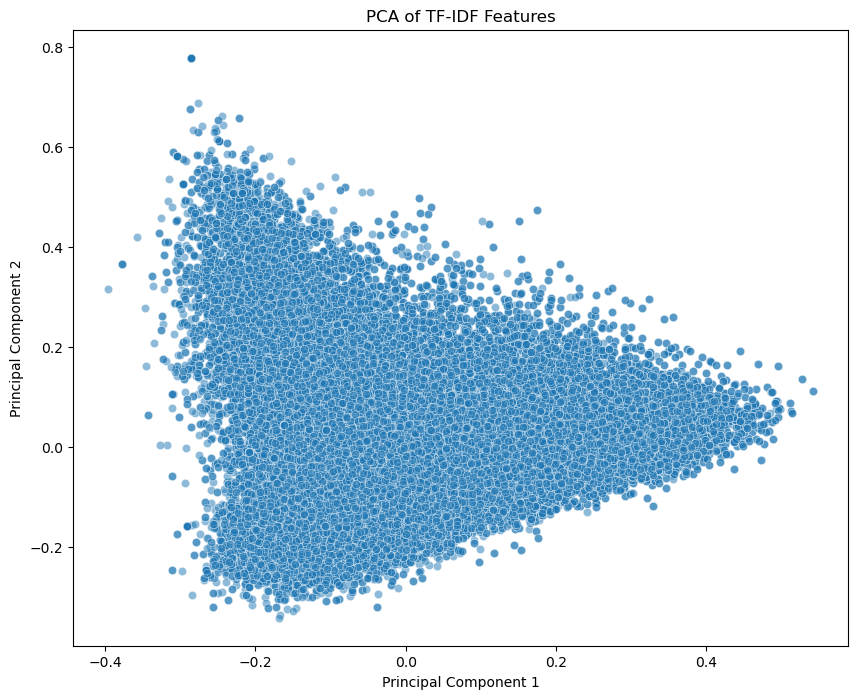

In [50]:
from sklearn.decomposition import PCA

# Check for the lemmatized review column
if 'lemmatized_review' in df1.columns:
    # Use the entire dataset for TF-IDF
    text_column = df1['lemmatized_review'].astype(str)
    
    # Initialize TF-IDF Vectorizer
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=500)
    X_tfidf = tfidf_vectorizer.fit_transform(text_column)

    # Display the shape of the TF-IDF matrix
    print("TF-IDF matrix shape:", X_tfidf.shape)

    # Convert to DataFrame for easier analysis
    tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
    
    # Display top terms by their mean TF-IDF score
    mean_tfidf_scores = tfidf_df.mean().sort_values(ascending=False)
    print("Top TF-IDF terms:\n", mean_tfidf_scores.head(10))

    # Visualize the top TF-IDF terms
    plt.figure(figsize=(10, 6))
    sns.barplot(x=mean_tfidf_scores.head(10).values, y=mean_tfidf_scores.head(10).index)
    plt.title('Top 10 TF-IDF Terms')
    plt.xlabel('Mean TF-IDF Score')
    plt.ylabel('Terms')
    plt.show()

    # Dimensionality reduction using PCA for visualization
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(X_tfidf.toarray())

    # Create a DataFrame for the PCA result
    pca_df = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])

    # Visualize PCA results
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='PC1', y='PC2', data=pca_df, alpha=0.5)
    plt.title('PCA of TF-IDF Features')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()


In [51]:

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to get sentiment score
def analyze_sentiment(text):
    if isinstance(text, str):
        return sia.polarity_scores(text)
    else:
        return {'neg': 0, 'neu': 0, 'pos': 0, 'compound': 0}

# Ensure that you have a column with the raw reviews, for example, 'review'
if 'review' in df1.columns:
    # Apply sentiment analysis to the raw review column
    df1['comments_review_sentiment'] = df1['review'].apply(analyze_sentiment)

    # Extract compound sentiment score
    df1['comments_sentiment_score'] = df1['comments_review_sentiment'].apply(lambda x: x['compound'])

    # Check the distribution of sentiment scores
    print("Sentiment score distribution:")
    print(df1['comments_sentiment_score'].describe())

    # Print sentiment scores for the top n rows
    print("Sentiment scores for comments reviews:")
    print(df1[['review', 'comments_sentiment_score']].head(10))

    # Identify reviews with significant sentiment scores
    significant_sentiment = df1[df1['comments_sentiment_score'].abs() > 0.1]  # Adjust the threshold as needed
    print("Reviews with significant sentiment scores:")
    print(significant_sentiment[['review', 'comments_sentiment_score']].head(10))


Sentiment score distribution:
count    215063.000000
mean         -0.042509
std           0.680252
min          -0.998400
25%          -0.726900
50%          -0.050700
75%           0.636900
max           0.995200
Name: comments_sentiment_score, dtype: float64
Sentiment scores for comments reviews:
                                              review  comments_sentiment_score
0  "It has no side effect, I take it in combinati...                   -0.2960
1  "My son is halfway through his fourth week of ...                    0.8603
2  "I used to take another oral contraceptive, wh...                    0.7962
3  "This is my first time using any form of birth...                    0.7184
4  "Suboxone has completely turned my life around...                    0.9403
5  "2nd day on 5mg started to work with rock hard...                   -0.4342
6  "He pulled out, but he cummed a bit in me. I t...                    0.0000
7  "Abilify changed my life. There is hope. I was...                

In [52]:
# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to get sentiment score
def analyze_sentiment(text):
    if isinstance(text, str):
        return sia.polarity_scores(text)
    else:
        return {'neg': 0, 'neu': 0, 'pos': 0, 'compound': 0}

# Apply sentiment analysis to the entire DataFrame
df1['comments_review_sentiment'] = df1['lemmatized_review'].apply(analyze_sentiment)

# Extract compound sentiment score
df1['comments_sentiment_score'] = df1['comments_review_sentiment'].apply(lambda x: x['compound'])

# Check the distribution of sentiment scores
print("Sentiment score distribution:")
print(df1['comments_sentiment_score'].describe())

# Print sentiment scores for the top 30 rows
print("Sentiment scores for comments reviews:")
print(df1[['lemmatized_review', 'comments_sentiment_score']].head(15))

# Identify reviews with significant sentiment scores
significant_sentiment = df1[df1['comments_sentiment_score'].abs() > 0.1]  # Adjust the threshold as needed
print("Reviews with significant sentiment scores:")
print(significant_sentiment[['lemmatized_review', 'comments_sentiment_score']].head(15))



Sentiment score distribution:
count    215063.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: comments_sentiment_score, dtype: float64
Sentiment scores for comments reviews:
                                    lemmatized_review  \
0   [side, effect, take, combination, bystolic, mg...   
1   [son, halfway, fourth, week, intuniv, became, ...   
2   [used, take, another, oral, contraceptive, pil...   
3   [first, time, using, form, birth, control, im,...   
4   [suboxone, completely, turned, life, around, f...   
5   [nd, day, mg, started, work, rock, hard, erect...   
6   [pulled, cummed, bit, took, plan, b, hour, lat...   
7   [abilify, changed, life, hope, zoloft, clonidi...   
8   [nothing, problem, keppera, constant, shaking,...   
9   [pill, many, year, doctor, changed, rx, chatea...   
10  [medication, almost, two, week, started, mg, w...   
11  [taken, antidepressant, year, improvement, mos...   

In [56]:
from sklearn.cluster import KMeans

#  'review' column exists
if 'review' in df1.columns:
    # Use TF-IDF for feature extraction
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    X_tfidf = tfidf_vectorizer.fit_transform(df1['review'].astype(str))

    # Apply K-means clustering
    n_clusters = 5  # Adjust the number of clusters as needed
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df1['cluster'] = kmeans.fit_predict(X_tfidf)

    # Print cluster assignments
    print("Cluster assignments for reviews:")
    print(df1[['review', 'cluster']].head(15))


Cluster assignments for reviews:
                                               review  cluster
0   "It has no side effect, I take it in combinati...        1
1   "My son is halfway through his fourth week of ...        1
2   "I used to take another oral contraceptive, wh...        4
3   "This is my first time using any form of birth...        4
4   "Suboxone has completely turned my life around...        1
5   "2nd day on 5mg started to work with rock hard...        1
6   "He pulled out, but he cummed a bit in me. I t...        1
7   "Abilify changed my life. There is hope. I was...        3
8   " I Ve had  nothing but problems with the Kepp...        1
9   "I had been on the pill for many years. When m...        4
10  "I have been on this medication almost two wee...        1
11  "I have taken anti-depressants for years, with...        1
12  "I had Crohn&#039;s with a resection 30 years ...        1
13  "Have a little bit of a lingering cough from a...        2
14  "Started Nexplanon

In [58]:
# Check for lemmatized review column
if 'lemmatized_review' in df1.columns:
    # Use TF-IDF for feature extraction
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    X_tfidf = tfidf_vectorizer.fit_transform(df1['lemmatized_review'].astype(str))

    # Apply K-means clustering
    n_clusters = 5  # Adjust the number of clusters as needed
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df1['cluster'] = kmeans.fit_predict(X_tfidf)

    # Print cluster assignments
    print("Cluster assignments for reviews:")
    print(df1[['lemmatized_review', 'cluster']].head(15))


Cluster assignments for reviews:
                                    lemmatized_review  cluster
0   [side, effect, take, combination, bystolic, mg...        4
1   [son, halfway, fourth, week, intuniv, became, ...        4
2   [used, take, another, oral, contraceptive, pil...        2
3   [first, time, using, form, birth, control, im,...        2
4   [suboxone, completely, turned, life, around, f...        4
5   [nd, day, mg, started, work, rock, hard, erect...        4
6   [pulled, cummed, bit, took, plan, b, hour, lat...        4
7   [abilify, changed, life, hope, zoloft, clonidi...        4
8   [nothing, problem, keppera, constant, shaking,...        4
9   [pill, many, year, doctor, changed, rx, chatea...        2
10  [medication, almost, two, week, started, mg, w...        3
11  [taken, antidepressant, year, improvement, mos...        4
12  [crohn, resection, year, ago, mostly, remissio...        4
13  [little, bit, lingering, cough, cold, giving, ...        4
14  [started, nexplano

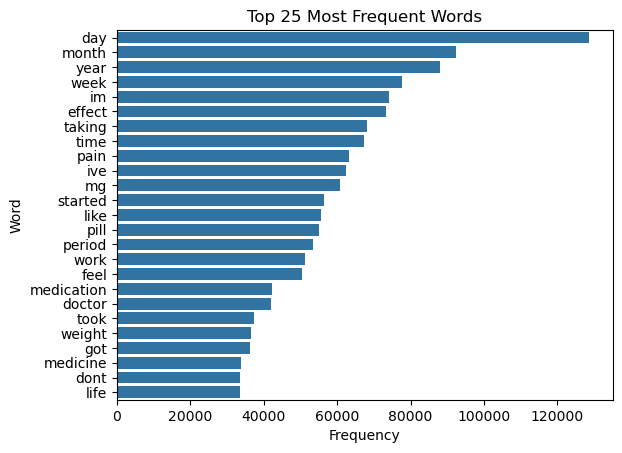

In [60]:
def plot_most_frequent_words(text_column, top_n=20):
    # Use CountVectorizer to get word frequencies
    vectorizer = CountVectorizer(stop_words='english', max_features=top_n)
    word_matrix = vectorizer.fit_transform(text_column)
    word_freq = np.asarray(word_matrix.sum(axis=0)).flatten()
    words = vectorizer.get_feature_names_out()

    # Create a DataFrame for plotting
    word_freq_dict = dict(zip(words, word_freq))
    sorted_words = sorted(word_freq_dict.items(), key=lambda x: x[1], reverse=True)
    word_df = pd.DataFrame(sorted_words, columns=['Word', 'Frequency'])

    # Plot the results
    sns.barplot(x='Frequency', y='Word', data=word_df)
    plt.title(f'Top {top_n} Most Frequent Words')
    plt.show()

# Check for the original review column
if 'lemmatized_review' in df1.columns:  
    # Plot the most frequent words in the entire dataset
    plot_most_frequent_words(df1['lemmatized_review'].astype(str), top_n=25)

In [62]:
# Check if necessary columns exist
if 'lemmatized_review' in df1.columns:  
    # Optionally limit the size of the dataset for faster processing
    max_rows = 100000  # Adjust this as needed
    text_column = df1['lemmatized_review'].astype(str).head(max_rows)  # Use only the top 'max_rows'

    # Use CountVectorizer for LDA with a limit on the number of features
    vectorizer = CountVectorizer(stop_words='english', max_features=200)  # Reduce max_features further
    X = vectorizer.fit_transform(text_column)

    # Apply LDA for topic modeling with fewer topics
    lda = LatentDirichletAllocation(n_components=3, random_state=42, n_jobs=-1)  # Use all available cores
    lda.fit(X)

    # Function to display top words in each topic
    def print_lda_topics(lda, vectorizer, top_n=10):
        words = vectorizer.get_feature_names_out()
        for i, topic in enumerate(lda.components_):
            print(f"Topic {i + 1}:")
            print([words[i] for i in topic.argsort()[-top_n:]])

    # Print the top words for each topic
    print_lda_topics(lda, vectorizer)



Topic 1:
['weight', 'year', 'day', 'week', 'control', 'im', 'ive', 'pill', 'period', 'month']
Topic 2:
['life', 'doctor', 'time', 'medicine', 'medication', 'effect', 'day', 'work', 'year', 'pain']
Topic 3:
['anxiety', 'like', 'effect', 'started', 'im', 'taking', 'feel', 'week', 'mg', 'day']


In [63]:
from textblob import TextBlob

# Function to analyze sentiment using TextBlob
def analyze_sentiment_textblob(text):
    if isinstance(text, str):
        return TextBlob(text).sentiment.polarity
    return 0

# Apply TextBlob sentiment analysis
df1['textblob_sentiment'] = df1['review'].apply(analyze_sentiment_textblob)
print("TextBlob sentiment score distribution:")
print(df1['textblob_sentiment'].describe())


TextBlob sentiment score distribution:
count    215063.000000
mean          0.064654
std           0.222380
min          -1.000000
25%          -0.043750
50%           0.057566
75%           0.173391
max           1.000000
Name: textblob_sentiment, dtype: float64


In [64]:
log_reg = LogisticRegression(max_iter=500)

# Step 1: Convert 'rating' to a binary target variable
# For example, consider ratings above 3 as effective (1) and below or equal to 3 as ineffective (0)
df1['effective'] = (df1['rating'] > 3).astype(int)

# Step 2: Prepare text features (lemmatized reviews) and numerical features (usefulCount)
X_text = df1['lemmatized_review'].astype(str)
X_numerical = df1[['usefulCount']]

# Step 3: Vectorization using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=2000)  # Adjust max_features as needed
X_tfidf = tfidf_vectorizer.fit_transform(X_text)

# Combine TF-IDF features with numerical features
from scipy.sparse import hstack
X_features = hstack([X_tfidf, X_numerical])

# Step 4: Prepare the target variable
y = df1['effective']

# Step 5: Split the data
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)

# Step 6: Train logistic regression model
log_reg = LogisticRegression(max_iter=200)  # Increase max_iter if needed
log_reg.fit(X_train, y_train)

# Step 7: Predictions
y_pred = log_reg.predict(X_test)

# Step 8: Classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.73      0.53      0.61      9423
           1       0.88      0.94      0.91     33590

    accuracy                           0.85     43013
   macro avg       0.80      0.74      0.76     43013
weighted avg       0.85      0.85      0.85     43013



/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [65]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Create a pipeline with scaling and logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),  # Set with_mean=False for sparse data
    ('log_reg', LogisticRegression())
])

# Define a reduced hyperparameter grid
param_grid = {
    'log_reg__C': [0.1, 1, 10],  # Fewer options for quicker runs
    'log_reg__max_iter': [200, 500],
    'log_reg__solver': ['liblinear'],  # Using a single solver for speed
}

# Initialize RandomizedSearchCV with fewer iterations
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grid,
    n_iter=10,  # Number of random parameter combinations to try
    cv=3,       # Reduce number of folds
    scoring='accuracy',
    n_jobs=-1,  # Use all available cores for parallel processing
    random_state=42  # For reproducibility
)

# Fit the model
random_search.fit(X_train, y_train)

# Best parameters and score
print("Best parameters:", random_search.best_params_)
print("Best cross-validation score:", random_search.best_score_)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters: {'log_reg__solver': 'liblinear', 'log_reg__max_iter': 200, 'log_reg__C': 1}
Best cross-validation score: 0.8548735832606801


In [ ]:
import transformers
import tf_keras

from transformers import pipeline

# Initialize sentiment-analysis pipeline with an explicit model
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

# Function to analyze sentiment using BERT
def analyze_sentiment_bert(text):
    if isinstance(text, str):
        return sentiment_pipeline(text)[0]['score']  # Get score from the first prediction
    return {'positive': 0, 'negative': 0}

# Apply BERT sentiment analysis to your DataFrame
df1['bert_sentiment'] = df1['review'].apply(analyze_sentiment_bert)

# Display the results
print("BERT sentiment analysis results:")
print(df1[['review', 'bert_sentiment']].head())


In [70]:
# Function to clean text
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'\d+', '', text) 
        text = re.sub(r'[^\w\s]', '', text) 
    return text

# Clean the reviews column
df2['cleaned_reviews'] = df2['reviews'].apply(clean_text)

# Check the cleaned column
print(df2[['cleaned_reviews']].head())


                                     cleaned_reviews
0  slowed the progression of left ventricular dys...
1  although this type of birth control has more c...
2  i was used to having cramps so badly that they...
3  the acid reflux went away for a few months aft...
4  i think that the lyrica was starting to help w...


In [72]:
# Ensure you have the stopwords downloaded
stop_words = set(stopwords.words('english'))

# Tokenization function
def tokenize_and_remove_stopwords(text):
    if isinstance(text, str):
        words = word_tokenize(text)
        words = [word for word in words if word not in stop_words]
        return words
    return []

# Apply tokenization to the cleaned_reviews column
df2['tokens_reviews'] = df2['cleaned_reviews'].apply(tokenize_and_remove_stopwords)

# Check the tokenized column
print(df2[['reviews', 'cleaned_reviews', 'tokens_reviews']].head())


                                             reviews  \
0  slowed the progression of left ventricular dys...   
1  Although this type of birth control has more c...   
2  I was used to having cramps so badly that they...   
3  The acid reflux went away for a few months aft...   
4  I think that the Lyrica was starting to help w...   

                                     cleaned_reviews  \
0  slowed the progression of left ventricular dys...   
1  although this type of birth control has more c...   
2  i was used to having cramps so badly that they...   
3  the acid reflux went away for a few months aft...   
4  i think that the lyrica was starting to help w...   

                                      tokens_reviews  
0  [slowed, progression, left, ventricular, dysfu...  
1  [although, type, birth, control, cons, pros, h...  
2  [used, cramps, badly, would, leave, balled, be...  
3  [acid, reflux, went, away, months, days, drug,...  
4  [think, lyrica, starting, help, pain, sideeffe..

In [74]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Lemmatization function
def lemmatize_words(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]

# Apply lemmatization to the tokens_reviews column
df2['lemmatized_reviews'] = df2['tokens_reviews'].apply(lemmatize_words)

# Check the lemmatized column
print(df2[['reviews', 'cleaned_reviews', 'tokens_reviews', 'lemmatized_reviews']].head())


                                             reviews  \
0  slowed the progression of left ventricular dys...   
1  Although this type of birth control has more c...   
2  I was used to having cramps so badly that they...   
3  The acid reflux went away for a few months aft...   
4  I think that the Lyrica was starting to help w...   

                                     cleaned_reviews  \
0  slowed the progression of left ventricular dys...   
1  although this type of birth control has more c...   
2  i was used to having cramps so badly that they...   
3  the acid reflux went away for a few months aft...   
4  i think that the lyrica was starting to help w...   

                                      tokens_reviews  \
0  [slowed, progression, left, ventricular, dysfu...   
1  [although, type, birth, control, cons, pros, h...   
2  [used, cramps, badly, would, leave, balled, be...   
3  [acid, reflux, went, away, months, days, drug,...   
4  [think, lyrica, starting, help, pain, sidee

In [76]:
# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Analyze sentiment function
def analyze_sentiment(tokens):
    text = ' '.join(tokens)
    return sia.polarity_scores(text)

# Apply sentiment analysis to the lemmatized_reviews
df2['reviews_sentiment'] = df2['lemmatized_reviews'].apply(analyze_sentiment)
df2['sentiment_score'] = df2['reviews_sentiment'].apply(lambda x: x['compound'])

# Check sentiment analysis results
print(df2[['sentiment_score', 'reviews_sentiment']].head())


   sentiment_score                                  reviews_sentiment
0          -0.9758  {'neg': 0.46, 'neu': 0.54, 'pos': 0.0, 'compou...
1           0.6486  {'neg': 0.178, 'neu': 0.594, 'pos': 0.228, 'co...
2          -0.6121  {'neg': 0.252, 'neu': 0.59, 'pos': 0.158, 'com...
3          -0.7783  {'neg': 0.105, 'neu': 0.895, 'pos': 0.0, 'comp...
4          -0.4939  {'neg': 0.193, 'neu': 0.719, 'pos': 0.088, 'co...


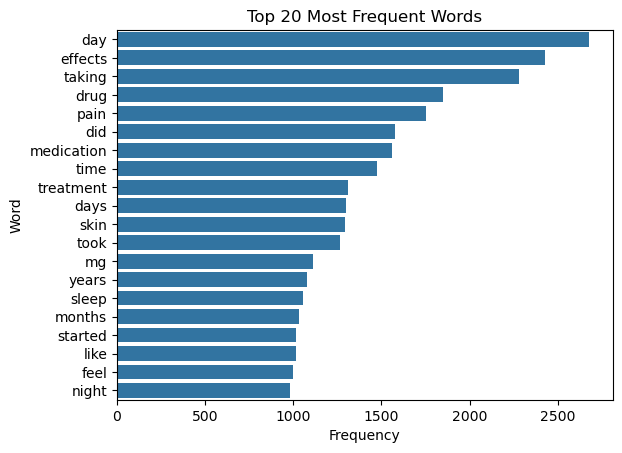

In [78]:
# Function to plot most frequent words
def plot_most_frequent_words(text_column, top_n=15):
    vectorizer = CountVectorizer(stop_words='english', max_features=top_n)
    word_matrix = vectorizer.fit_transform(text_column)
    word_freq = np.asarray(word_matrix.sum(axis=0)).flatten()
    words = vectorizer.get_feature_names_out()

    word_freq_dict = dict(zip(words, word_freq))
    sorted_words = sorted(word_freq_dict.items(), key=lambda x: x[1], reverse=True)
    word_df = pd.DataFrame(sorted_words, columns=['Word', 'Frequency'])

    sns.barplot(x='Frequency', y='Word', data=word_df)
    plt.title(f'Top {top_n} Most Frequent Words')
    plt.show()

# Analyze the whole dataset using the 'reviews' column
if 'reviews' in df2.columns:
    plot_most_frequent_words(df2['reviews'].astype(str), top_n=20)

In [80]:
# Topic modeling on reviews
if 'reviews' in df2.columns:
    # Use the entire dataset instead of sampling
    text_column = df2['reviews'].astype(str)

    # Create the CountVectorizer
    vectorizer = CountVectorizer(stop_words='english', max_features=500)
    X = vectorizer.fit_transform(text_column)

    # Apply LDA for topic modeling
    lda = LatentDirichletAllocation(n_components=3, random_state=42)
    lda.fit(X)

    # Function to display top words in each topic
    def print_lda_topics(lda, vectorizer, top_n=10):
        words = vectorizer.get_feature_names_out()
        for i, topic in enumerate(lda.components_):
            print(f"Topic {i + 1}:")
            print([words[i] for i in topic.argsort()[-top_n:]])

    # Display the topics
    print_lda_topics(lda, vectorizer)

Topic 1:
['severe', 'did', 'medication', 'took', 'drug', 'effects', 'taking', 'days', 'day', 'pain']
Topic 2:
['pressure', 'dry', 'face', 'day', 'use', 'effects', 'treatment', 'blood', 'acne', 'skin']
Topic 3:
['medication', 'feel', 'depression', 'time', 'drug', 'sleep', 'mg', 'effects', 'day', 'taking']
